# How well does the DREAM model predict the pleasantness of the 10 molecules in the "Universal Pleasantness" project?`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Built-in or external libraries
%matplotlib inline
import os
import sys
import pickle
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import seaborn as sns
sns.set(font_scale=1.5)

### 2) Load olfaction prediction libraries

In [3]:
# Internal libraries
import opc_python
# For loading data into dataframes
from opc_python.utils import loading
# dream contains lots of important functions related to model building
# fit2 is specifically subchallenge 2 related (fitting mean and stdev) when the data is ready
# params contains functions for obtaining or looking up previously obtained hyperparameters
from opc_python.gerkin import dream, params, fit1, fit2
OP_PATH = pathlib.Path(opc_python.__file__).parent

In [30]:
all_CID_dilutions = loading.get_CID_dilutions(['training', 'leaderboard', 'testset'])

### 3) All other settings

In [8]:
# Which feature sets do you want to use?
FEATURE_SETS = ['dragon', 'episuite', 'morgan', 'nspdk', 'gramian']

# Which datasets do you want to train on?
# Optionally replace this with some other list of CID/dilution pairs, 
# e.g. pd.DataFrame([(126, -3), (176, -5), (240, -1)], columns=['CID', 'Dilution'])
all_CID_dilutions = loading.get_CID_dilutions(['training', 'leaderboard', 'testset'])
#all_CID_dilutions = all_CID_dilutions.to_frame().reset_index(drop=1)

# Which datasets do you want to test on?
# Optionally replace this with a dataframe of other CIDs/dilution pairs, 
# e.g. pd.DataFrame([(196, -3), (239, -1), (261, -5), columns=['CID', 'Dilution'])
# Wrong:
#other_CIDs = [1183, 6549, 3314, 7762, 6054, 18827, 9261, 379, 9609, 10430]
# Corrected:
other_CIDs = [1183, 6549, 3314, 7762, 6054, 18827, 32594, 379, 8077, 10430]
#TRAINING_CID_DILUTIONS = all_CID_dilutions[~all_CID_dilutions['CID'].isin(other_CIDs)]
TRAINING_CID_DILUTIONS = all_CID_dilutions[~all_CID_dilutions.get_level_values('CID').isin(other_CIDs)]
#TESTING_CID_DILUTIONS = all_CID_dilutions[all_CID_dilutions['CID'].isin(other_CIDs)]
TESTING_CID_DILUTIONS = all_CID_dilutions[all_CID_dilutions.get_level_values('CID').isin(other_CIDs)]

# Which subjects do you want to build a model for (or for the mean or stdev across subjects)
SUBJECT = 'mean' # Other options are 'stdev' or an integer subject number

# What dilution do you want to evaluate model quality on (other dilutions will still be used for training)
DILUTION = 'gold' # An integer (e.g. -3 for 1/1000) or the values 'high', 'low', or 'gold'
# high will be the most concentrated
# low will be the least concentrated
# gold is -3 for intensity and high for all other descriptors

# What descriptors do you want to model?
# Use an empty list or `None` for all of them.  
DESCRIPTORS = ['Pleasantness']

# Number of decision trees to use.  More trees means longer computation time.  
# Accuracy saturates beyond ~200
N_ESTIMATORS = 250

# Save the models that you fit
SAVE_MODELS = True

# Load the models instead of fitting them
LOAD_MODELS = False

# Where will the models be?
# The location to load/save the model that was not trained on the test data
TRAINED_MODELS_PATH = OP_PATH / 'models' / 'models_train_pleas_10.pickle'
# The location to load/save the model that uses all the data (including test data)
FULL_MODELS_PATH = OP_PATH / 'models' / 'models_full_pleas_10.pickle'

# Optional: path to stored .csv files of features. Not necessary if using DREAM molecules
FEATURES_PATH = OP_PATH / 'features'

In [62]:
loading.pool_CID_dilutions([TRAINING_CID_DILUTIONS, TESTING_CID_DILUTIONS])

MultiIndex([(  126, -3.0),
            (  126, -1.0),
            (  176, -7.0),
            (  176, -5.0),
            (  177, -5.0),
            (  177, -3.0),
            (  180, -3.0),
            (  180, -1.0),
            (  196, -3.0),
            (  196, -1.0),
            ...
            ( 7762, -5.0),
            ( 7762, -3.0),
            ( 8077, -5.0),
            ( 8077, -3.0),
            (10430, -7.0),
            (10430, -5.0),
            (18827, -5.0),
            (18827, -3.0),
            (32594, -5.0),
            (32594, -3.0)],
           names=['CID', 'Dilution'], length=910)

### 4) Load all data

In [63]:
# Get all descriptor names in DREAM paper format
descriptors = loading.get_descriptors(format=True)

# Get all CIDs
all_CID_dilutions = loading.pool_CID_dilutions([TRAINING_CID_DILUTIONS, TESTING_CID_DILUTIONS])
all_CIDs = all_CID_dilutions.get_level_values('CID').unique()

raw_perceptual_data = loading.load_raw_bmc_data()
perceptual_data = loading.format_bmc_data(raw_perceptual_data,
                                          only_dream_subjects=False, # Whether to only keep DREAM subjects
                                          only_dream_descriptors=True, # Whether to only keep DREAM descriptors
                                          only_dream_molecules=True) # Whether to only keep DREAM molecules)
perceptual_data.head()

Subject                             1    2    3    4    5   6    7    8    9   \
Descriptor CID Dilution Replicate                                               
Acid       126 -3.0     0          0.0  0.0  0.0  0.0  NaN NaN  0.0  0.0  NaN   
               -1.0     0          0.0  0.0  NaN  0.0  0.0 NaN  0.0  0.0  0.0   
           176 -7.0     0          NaN  NaN  NaN  0.0  NaN NaN  NaN  NaN  NaN   
               -5.0     0          NaN  0.0  0.0  NaN  0.0 NaN  NaN  0.0  NaN   
           177 -5.0     0          0.0  0.0  NaN  0.0  NaN NaN  0.0  NaN  NaN   

Subject                             10  ...    46   47   48   49   50   51  \
Descriptor CID Dilution Replicate       ...                                  
Acid       126 -3.0     0          0.0  ...   NaN  NaN  0.0  0.0  0.0  0.0   
               -1.0     0          0.0  ...  32.0  0.0  NaN  0.0  0.0  0.0   
           176 -7.0     0          NaN  ...   NaN  NaN  1.0  NaN  0.0  0.0   
               -5.0     0          NaN  ...   NaN  NaN  NaN  NaN  0.0  NaN   
           177 -5.0     0          0.0  ...   0.0  NaN  NaN  0.0  0.0  0.0   

Subject                             52   53   54   55  
Descriptor CID Dilution Replicate                      
Acid       126 -3.0     0          NaN  NaN  NaN  0.0  
               -1.0     0          1.0  0.0  0.0  0.0  
           176 -7.0     0          NaN  NaN  NaN  NaN  
               -5.0     0          NaN  NaN  0.0  NaN  
           177 -5.0     0          2.0  0.0  NaN  NaN  

[5 rows x 55 columns]

In [64]:
# Get all molecular data, i.e. physicochemical features
molecular_data = loading.get_molecular_data(FEATURE_SETS, all_CIDs)
molecular_data.head()

Dragon has 4869 features for 476 molecules.
Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
Nspdk has 6163 features for 476 molecules.
Gramian has 2437 features for 476 molecules.
There are now 15968 total features.


dragon                                                 \
    complexity from pubmed      MW    AMW      Sv      Se      Sp      Si   
CID                                                                         
126                   93.1  122.13  8.142  10.010  15.305  10.193  16.664   
176                   31.0   60.06  7.508   4.483   8.422   4.432   9.249   
177                   10.3   44.06  6.294   3.768   7.095   3.977   8.040   
180                   26.3   58.09  5.809   5.295   9.978   5.739  11.455   
196                  114.0  146.16  7.308  11.493  20.727  11.625  22.914   

                          ...   gramian                                \
        Mv     Me     Mp  ...      2427      2428      2429      2430   
CID                       ...                                           
126  0.667  1.020  0.680  ...  0.001105  0.005903  0.194120  0.009947   
176  0.560  1.053  0.554  ...  0.031582  0.031028  0.049205  0.029624   
177  0.538  1.014  0.568  ...  0.046884  0.063734  0.014951  0.118445   
180  0.530  0.998  0.574  ...  0.098367  0.112621  0.021022  0.155485   
196  0.575  1.036  0.581  ...  0.116153  0.085972  0.033306  0.078286   

                                                                 
         2431      2432      2433      2434      2435      2436  
CID                                                              
126  0.197298  0.025006  0.246386  0.170887  0.043503  0.076089  
176  0.015334  0.063330  0.013679  0.014956  0.087638  0.025581  
177  0.026979  0.128351  0.043521  0.076143  0.045424  0.054192  
180  0.043382  0.152893  0.055474  0.074125  0.095945  0.085333  
196  0.033030  0.114937  0.026623  0.018514  0.175366  0.056830  

[5 rows x 15968 columns]

### 5) Build the matrix of predictors and the vectors of target data

In [19]:
# Create the X matrix from the molecular data in the training set.
# Several other arguments are available; see dream.py
X, metadata = dream.make_X(molecular_data, all_CID_dilutions)

/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


The X matrix now has shape (910x8010) molecules by non-NaN good molecular descriptors
3082 descriptors come from dragon.
2435 descriptors come from gramian.
2435 descriptors come from morgan.
56 descriptors come from episuite.
1 descriptors come from nspdk.


In [20]:
# TO DO: Get a fuller list of nspdk features with fewer NaNs so more are retained by `dream.make_X`

In [21]:
# Create the Y matrix from the perceptual data in the training set.
# Several other arguments are available; see dream.py
Y = dream.make_Y(perceptual_data)

In [22]:
# Make sure that our molecular and perceptual data are aligned. 
left = X.join(Y, how='left')
right = X.join(Y, how='right')
inner = X.join(Y, how='inner')
print(("There are %d CID/dilution combinations for which we have molecular but not "
       "perceptual data, %d for which we have perceptual but not molecular data, "
       "and %d for which we have both. ") % (len(X) - len(right), len(Y) - len(left), len(inner)))

# Remove those CID/dilution combinations from the molecular data
X = X.loc[inner.index]
Y = Y.loc[inner.index]

There are -42 CID/dilution combinations for which we have molecular but not perceptual data, 42 for which we have perceptual but not molecular data, and 910 for which we have both. 


/opt/conda/lib/python3.7/site-packages/pandas/core/reshape/merge.py:617: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [26]:
# Update the testing CID/dilutions combinations to reflect this and create tuples for easy selection
training_CID_dilutions = TRAINING_CID_DILUTIONS.values # As CID/dilution tuples
testing_CID_dilutions = TESTING_CID_DILUTIONS.values # As CID/dilution tuples
we_have = list(inner.index) # Tuples of CID/dilutions we have both molecular and perceptual data for
training_CID_dilutions = list(set(training_CID_dilutions).intersection(we_have)) # Restrict the set we will train on
testing_CID_dilutions = list(set(testing_CID_dilutions).intersection(we_have)) # Restrict the set we will test on

### 6) Split into training and testing sets

In [27]:
X_train = X.loc[training_CID_dilutions]
X_test = X.loc[testing_CID_dilutions]
Y_train = Y.loc[training_CID_dilutions]
Y_test = Y.loc[testing_CID_dilutions]
assert X_train.shape[0] == Y_train.shape[0]
assert X_test.shape[0] == Y_test.shape[0]
print("We now have %d CID/dilution combinations for training and %d for testing" \
      % (X_train.shape[0], X_test.shape[0]))

We now have 891 CID/dilution combinations for training and 19 for testing


In [28]:
# Impute missing values for perceptual training data
Y_imp = dream.impute(Y_train, 'median')

### 7) Load previously computed hyperparameters for model fitting

In [29]:
# Load hyperparameters previously obtained via cross-validation
# use_et = use ExtraTrees instead of RandomForest
# regularize = balance between subject-specific fits and population fits (not used for mean prediction)
# use_mask = use masked data instead of imputed data for training
hp = params.get_hyperparams('mean')
hp.head()

,use_et,max_features,max_depth,min_samples_leaf,regularize,use_mask
Intensity,True,None,None,1,0.8,False
Pleasantness,False,None,None,1,0.7,False
Bakery,False,None,6,1,0.9,False
Sweet,False,None,None,1,0.8,False
Fruit,False,None,15,1,0.8,False


In [30]:
# Determine translation parameters 
# (for translating mean predictions into standard deviation predictions)
trans_params = params.get_trans_params(Y, descriptors, plot=False)

### 8) Fit the models for each descriptor

In [31]:
# Increase n_estimators to get better fits; full model uses ~100.  
# Set std to True to also predict standard deviations
if LOAD_MODELS:
    with open(TRAINED_MODELS_PATH, 'rb') as f:
        models, _ = pickle.load(f)
else:
    models = fit2.rfc_fit_models(X_train, # Molecular data for training
                                 Y_train, # Perceptual data for training
                                 Y_imp, # Perceptual data with missing values imputed
                                 hp, # Dataframe of hyperparameters for each descriptor
                                 n_estimators=N_ESTIMATORS, # Number of decision trees
                                 std=(SUBJECT=='StDev'), # Whether to fit models for the standard deviatio
                                 descriptors=DESCRIPTORS)

[-----------------------100%---------------------] 1 out of 1 complete (All descriptors' models have been fit)


In [32]:
if SAVE_MODELS:
    with open(TRAINED_MODELS_PATH, 'wb') as f:
        pickle.dump((models, list(X_train)), f) # Store the models and the features and feature values they were trained on

### 9) In-sample predictions

In [33]:
# Get predicted ratings using the models applied to the test molecular data, restricted to DILUTION
predicted = fit2.rfc_get_predictions(models, # The models for each descriptor that you just fit or loaded 
                                     X_train, # Molecular data for testing
                                     dilution=DILUTION) # A dilution to restrict testing to

# Get the observed data for the test molecules, restricted to DILUTION
observed = fit2.get_observed(Y_train, # Perceptual data for testing
                             dilution=DILUTION) # A dilution to restrict testing to

fit2.summarize_fit(predicted, observed, 'mean', DESCRIPTORS)

Pleasantness    0.985039
Name: R, dtype: float64

### 10) Make predictions on the testset data for each model and descriptor

In [34]:
# Get predicted ratings using the models applied to the test molecular data, restricted to DILUTION
predicted_out = fit2.rfc_get_predictions(models, # The models for each descriptor that you just fit or loaded 
                                         X_test, # Molecular data for testing
                                         dilution=DILUTION) # A dilution to restrict testing to

### 11) Check predictions against testset data

In [35]:
# Get the observed data for the test molecules, restricted to DILUTION
observed = fit2.get_observed(Y_test, # Perceptual data for testing
                             dilution=DILUTION) # A dilution to restrict testing to

In [36]:
fit2.summarize_fit(predicted_out, observed, 'mean', DESCRIPTORS)

Pleasantness    0.859753
Name: R, dtype: float64

### 12) Fit models on all data and save models for future samples

In [37]:
# Impute missing values for all perceptual data
Y_imp = dream.impute(Y, 'median')

In [38]:
if LOAD_MODELS:
    with open(FULL_MODELS_PATH, 'rb') as f:
        models, _ = pickle.load(f)

else:
    models = fit2.rfc_fit_models(X, # Molecular data for training
                                 Y, # Perceptual data for training
                                 Y_imp, # Perceptual data with missing values imputed
                                 hp, # Dataframe of hyperparameters for each descriptor
                                 n_estimators=N_ESTIMATORS, # Number of decision trees
                                 std=(SUBJECT=='StDev'), # Whether to fit models for the standard deviatioif SAVE_MODELS:
                                 descriptors=DESCRIPTORS)

if SAVE_MODELS:
    with open(FULL_MODELS_PATH, 'wb') as f:
        pickle.dump((models, list(X)), f) # Store the models and the feature names

[-----------------------100%---------------------] 1 out of 1 complete (All descriptors' models have been fit)


In [39]:
# Get predicted ratings using the models applied to the test molecular data, restricted to DILUTION
# This is an in sample prediction, but only for the molecules in X_test.  
predicted_in = fit2.rfc_get_predictions(models, # The models for each descriptor that you just fit or loaded 
                                        X_test, # Molecular data for testing
                                        dilution=DILUTION) # A dilution to restrict testing to

fit2.summarize_fit(predicted_in, observed, 'mean', DESCRIPTORS)

Pleasantness    0.993482
Name: R, dtype: float64

In [40]:
columns = pd.MultiIndex.from_tuples([(descriptor, kind) for descriptor in DESCRIPTORS 
                                                        for kind in ['Observed', 'Predicted_IN', 'Predicted_OUT']])
summary = pd.DataFrame(index=observed['mean'].index, columns=columns)
for d in DESCRIPTORS:
    summary.loc[:, (d, 'Observed')] = observed['mean'][d].round(1)
    summary.loc[:, (d, 'Predicted_IN')] = predicted_in['mean'][d].round(1)
    summary.loc[:, (d, 'Predicted_OUT')] = predicted_out['mean'][d].round(1)

In [46]:
summary.to_csv('pleasantness-10-results.csv')

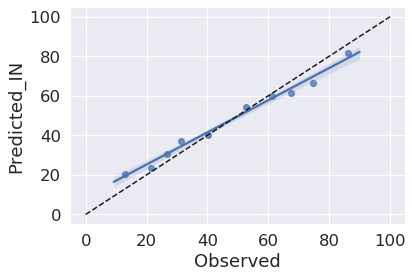

In [43]:
sns.regplot(x='Observed', y='Predicted_IN', data=summary['Pleasantness'], color='b')
plt.plot([0, 100], [0, 100], '--k');

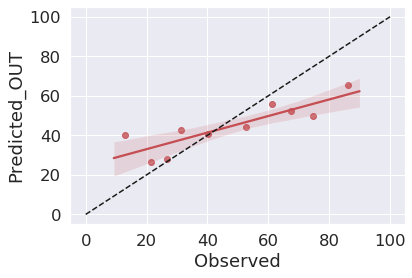

In [44]:
sns.regplot(x='Observed', y='Predicted_OUT', data=summary['Pleasantness'], color='r')
plt.plot([0, 100], [0, 100], '--k');

In [45]:
pwd

'/home/rgerkin/olfaction/olfaction-prediction/opc_python/paper'